# Inset to focus on some area of the map

This notebook shows an example of a UK-wide map of stroke units and catchment areas with a bonus inset image that shows a zoom-in of London.

## Notebook setup

In [1]:
import stroke_maps.load_data
import stroke_maps.catchment
import stroke_maps.geo

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mapclassify import greedy  # to assign colours to regions on map.
                                # ^ also requires libpysal.

## Load the stroke unit data

Postcodes, stroke team names, services etc. are stored in this dataframe:

In [2]:
df_units = stroke_maps.load_data.stroke_unit_region_lookup()

Coordinates of each stroke unit are stored in here:

In [3]:
gdf_units = stroke_maps.load_data.stroke_unit_coordinates()

Merge the unit names and services into the coordinates:

In [4]:
gdf_units = pd.merge(
    gdf_units, df_units,
    left_index=True, right_index=True, how='right'
)

In [5]:
gdf_units.head(3).T

postcode,SY231ER,CB20QQ,L97AL
BNG_E,259208,546375,338020
BNG_N,281805,254988,397205
Latitude,52.416068,52.173741,53.467918
Longitude,-4.071578,0.139114,-2.935131
geometry,POINT (259208 281805),POINT (546375 254988),POINT (338020 397205)
stroke_team,Bronglais Hospital (Aberystwyth),"Addenbrooke's Hospital, Cambridge","University Hospital Aintree, Liverpool"
short_code,AB,AD,AI
ssnap_name,Bronglais Hospital,Addenbrooke's Hospital,University Hospital Aintree
use_ivt,1,1,1
use_mt,0,1,1


__LSOA regions__:

In [6]:
gdf_lsoa = stroke_maps.load_data.lsoa_geography()

The following colour list is used to colour the catchment areas in the maps.

In [7]:
# Make a list of colour names:
# Expecting to only need a few colours for this example.
colours = ['Indigo', 'Purple', 'DarkOrchid', 'MediumOrchid', 'Orchid', 'Plum', 'Lavender']

# Make a dictionary of numbers to colours.
# The keys are the numbers in the `adjacent_colours` column:
keys = [f'{i}' for i in range(len(colours))]
colour_map = dict(zip(keys, colours))

## Calculate LSOA catchment areas

First we'll create a map of the normal stroke unit catchment areas in the West Midlands when we don't restrict anything.

Limit the travel time matrix to only stroke units that offer acute care. These are units where `use_ivt` and/or `use_mt` are equal to 1 (one).

In [8]:
mask = ((df_units['use_ivt'] == 1) | (df_units['use_mt'] == 1))
postcodes_units = df_units[mask].index.values

# Load the travel time matrix:
df_travel_lsoa = stroke_maps.load_data.travel_time_matrix_lsoa()
# Limit it to these units:
df_travel_lsoa = df_travel_lsoa[postcodes_units].copy()

Run the function to find which of the units in the reduced dataframe is closest to each LSOA:

In [9]:
df_catchment = stroke_maps.catchment.find_nearest_unit(df_travel_lsoa)

Combine this data with geometry:

In [10]:
# Merge in the information on nearest acute stroke unit:
gdf_lsoa = pd.merge(
    gdf_lsoa, df_catchment['unit_postcode'],
    left_on='LSOA11NM', right_index=True, how='right'
)
# Combine LSOA with the same acute stroke unit into a single region:
gdf_catchment = stroke_maps.geo.combine_regions(gdf_lsoa, 'unit_postcode')
# Convert the coordinates to British National Grid so that they match other geometry:
gdf_catchment = gdf_catchment.to_crs('EPSG:27700')
# Assign colours:
# Use balance='distance' option to use as few colours as possible.
# It does take longer to run though.
gdf_catchment['adjacent_colours'] = greedy(
    gdf_catchment, min_distance=1, balance='distance').astype(str)
# Assign these colours to the regions:
gdf_catchment['colour_str'] = gdf_catchment['adjacent_colours'].map(colour_map)

## Plot

First load the outline of England and Wales:

In [11]:
gdf_ew = stroke_maps.load_data.englandwales_outline()

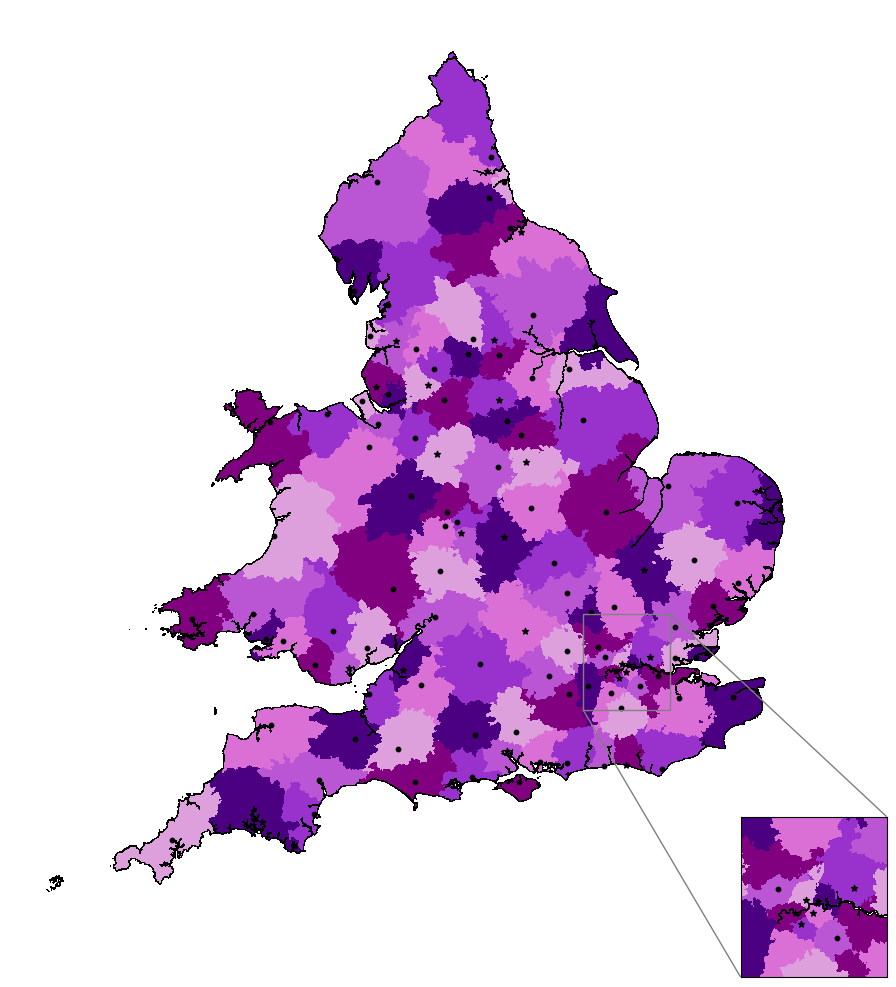

In [12]:
fig, ax = plt.subplots(figsize=(12, 12))
# Create inset axis in bottom right corner.
# x left anchor, y bottom anchor, width, height.
# If you define an axis that will fall outside the figure limits,
# pyplot will quietly move the fig boundaries around to accommodate it.
axins = ax.inset_axes([0.9, -0.05, 0.18, 0.18])

def plot_map(gdf_ew, gdf_catchment, gdf_units, ax):
    # Plot the catchment areas:
    gdf_catchment.plot(
        ax=ax,              # Set which axes to use for plot
        antialiased=False,  # Avoids artefact boundary lines
        color=gdf_catchment['colour_str'],  # set colours using this column
        linewidth=0.2,
        )
    
    # Plot the country outlines:
    gdf_ew.plot(
        ax=ax,              # Set which axes to use for plot
        antialiased=False,  # Avoids artefact boundary lines
        facecolor='none',
        edgecolor='k',
        linewidth=0.2,
        )
    
    # Pick out which stroke units to plot:
    mask_ivt = ((gdf_units['use_ivt'] == 1) & (gdf_units['use_mt'] == 0))
    mask_mt = (gdf_units['use_mt'] == 1)
    
    # IVT units:
    ax.scatter(
        gdf_units.loc[mask_ivt, 'geometry'].x,
        gdf_units.loc[mask_ivt, 'geometry'].y,
        marker='o',
        color='k',
        label='IVT unit',
        s=10,  # size
        )
    
    # MT units:
    ax.scatter(
        gdf_units.loc[mask_mt, 'geometry'].x,
        gdf_units.loc[mask_mt, 'geometry'].y,
        marker='*',
        color='k',
        label='MT unit',
        s=20,  # size
        )    

# ----- Main map -----
plot_map(gdf_ew, gdf_catchment, gdf_units, ax)


# ----- London inset -----
# Identify London hospitals to go in the inset map
london_mask = gdf_units['region'].str.contains('London')
london_hospitals = gdf_units[london_mask].index.to_list()
london_units = gdf_units[london_mask]

# # Identify map area to plot in the inset map.
# Limit catchment areas to just the stroke units in London:
gdf_catchment_here = gdf_catchment[
    gdf_catchment.index.isin(london_hospitals)].copy()

minx_, miny_, maxx_, maxy_ = gdf_catchment_here.total_bounds

# Set extent of inset map
axins.set_xlim(minx_, maxx_)
axins.set_ylim(miny_, maxy_)

# Remove axis tick labels:
axins.set_xticks([])
axins.set_yticks([])

# Define lines connecting inset map to main map
mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="0.5")

# Plot inset map of London
plot_map(gdf_ew, gdf_catchment, london_units, axins)


# ----- Figure setup -----
# Remove the axis border, ticks, labels...
ax.axis('off')

plt.show()